# 4. Slug test for confined aquifer - Dawsonville Example
**This test is taken from example of MLU.**

## Introduction and Conceptual Model

In this notebook, we reproduce the work of Yang (2020) to check the TTim performance in analysing slug-test. We later compare the solution in TTim with the MLU model (Carlson & Randall, 2012).

This Slug Test was reported in Cooper Jr et al. (1967), and it was performed in Dawsonville, Georgia, USA. A fully penetrated well (Ln-2) is screened in a confined aquifer, located between depths 24 and 122 (98 m thick).

The volume of the slug is 10.16 litres. Head change has been recorded at the slug well. Both the well and the casing radii of the slug well is 0.076 m.

The conceptual model can be seen in the figure below:

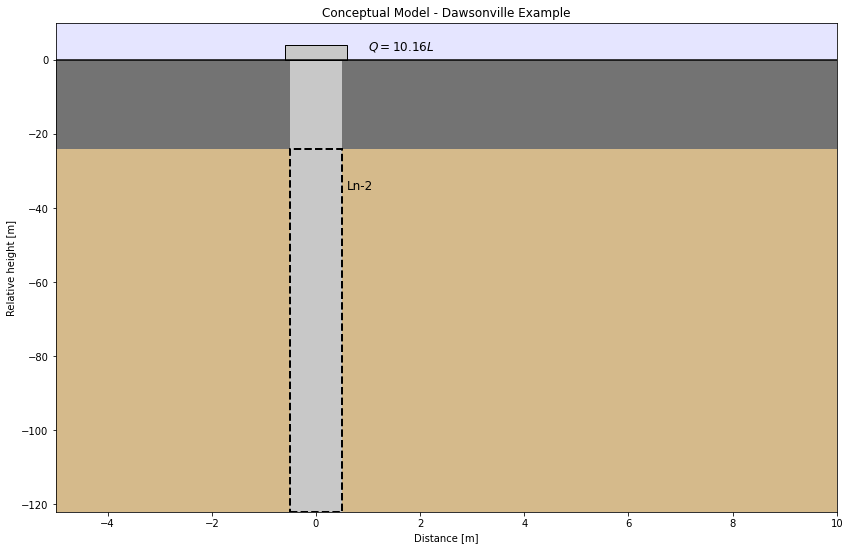

In [1]:
import matplotlib.pyplot as plt
import numpy as np

##Now printing the conceptual model figure:

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(1, 1, 1)
# sky
sky = plt.Rectangle((-5, 0), width=15, height=10, fc="b", zorder=0, alpha=0.1)
ax.add_patch(sky)

# Aquifer:
ground = plt.Rectangle(
    (-5, -122),
    width=15,
    height=98,
    fc=np.array([209, 179, 127]) / 255,
    zorder=0,
    alpha=0.9,
)
ax.add_patch(ground)

well = plt.Rectangle(
    (-0.5, -(122)), width=1, height=122, fc=np.array([200, 200, 200]) / 255, zorder=1
)
ax.add_patch(well)

# Confining Unit
conf = plt.Rectangle(
    (-5, -24),
    width=15,
    height=24,
    fc=np.array([100, 100, 100]) / 255,
    zorder=0,
    alpha=0.9,
)
ax.add_patch(conf)

# Wellhead
wellhead = plt.Rectangle(
    (-0.6, 0), width=1.2, height=4, fc=np.array([200, 200, 200]) / 255, zorder=2, ec="k"
)
ax.add_patch(wellhead)

# Screen for the well:
screen = plt.Rectangle(
    (-0.5, -(122)),
    width=1,
    height=98,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen.set_linewidth(2)
ax.add_patch(screen)
# pumping_arrow = plt.Arrow(x = 1,y = 1.5, dx = 0, dy = 1, color = "#00035b")
# ax.add_patch(pumping_arrow)
ax.text(x=1, y=2.5, s=r"$ Q = 10.16 L $", fontsize="large")


# last line
line = plt.Line2D(xdata=[-200, 1200], ydata=[0, 0], color="k")
ax.add_line(line)

# Water table
# wt = plt.Line2D(xdata= [-200,1200], ydata = [0,0], color = "b")
# ax.add_line(wt)

ax.text(0.6, -35, s="Ln-2", fontsize="large")
# ax.text(6.9, -0.5, "Ln-3", fontsize = 'large')
ax.set_xlim([-5, 10])
ax.set_ylim([-122, 10])
ax.set_xlabel("Distance [m]")
ax.set_ylabel("Relative height [m]")
ax.set_title("Conceptual Model - Dawsonville Example")

## Step 1. Load required libraries

In [2]:
from ttim import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Step 2. Set basic parameters

In [3]:
b = 98  # aquifer thickness
zt = -24
zb = zt - b
rw = 0.076  # well radius of Ln-2 Well
rc = 0.076  # casing radius of Ln-2 Well
Q = 0.01016  # slug volume in m^3

## Step 3. Load data

Data for the Dawsonville test is available in a text file, where the first column is the time data, in days and in the second column is the head displacement in meters

In [4]:
data = np.loadtxt("data/dawsonville_slug.txt")
t = data[:, 0]
h = data[:, 1]

## Step 4. Create First Model - single layer

We begin with a single layer model built in ModelMaq.
Details on setting up the model can be seen in: [Confined 1 - Oude Korendijk](confined1_oude_korendijk.ipynb).

The slug well is set accordingly. Details on setting up the ```Well``` object can be seen in: [Slug 1 - Pratt County](slug1_pratt_county.ipynb).

In [5]:
ml = ModelMaq(kaq=10, z=[zt, zb], Saq=1e-4, tmin=1e-6, tmax=1e-3, topboundary="conf")
w = Well(ml, xw=0, yw=0, rw=rw, rc=rc, tsandQ=[(0, -Q)], layers=0, wbstype="slug")
ml.solve()

self.neq  1
solution complete


## Step 5. Model calibration both simultaneous wells


The procedures for calibration can be seen in [Unconfined 1 - Vennebulten](unconfined1_vennebulten.ipynb)

We calibrate hydraulic conductivity and specific storage, as in the KGS model (Hyder et al. 1994).

In [6]:
# unknown parameters: kay, Saq
ca = Calibrate(ml)
ca.set_parameter(name="kaq0", initial=10, pmin=0)
ca.set_parameter(name="Saq0", initial=1e-4)
ca.series(name="obs", x=0, y=0, layer=0, t=t, h=h)
ca.fit(report=True)

............................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 22
    # variables        = 2
    chi-square         = 4.2779e-04
    reduced chi-square = 2.1389e-05
    Akaike info crit   = -234.654488
    Bayesian info crit = -232.472403
[[Variables]]
    kaq0:  0.42113030 +/- 0.01842476 (4.38%) (init = 10)
    Saq0:  1.6938e-05 +/- 5.2880e-06 (31.22%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.985


In [7]:
display(ca.parameters)
print("rmse:", ca.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,0.42113,0.018425,4.375074,0,inf,10,[0.42113029595796414]
Saq0,0.000017,0.000005,31.219119,-inf,inf,0.0001,[1.6938294179330807e-05]


rmse: 0.004409624944092217


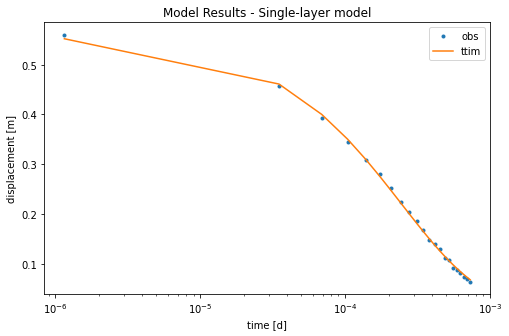

In [8]:
hm = ml.head(0, 0, t)
plt.figure(figsize=(8, 5))
plt.semilogx(t, h, ".", label="obs")
plt.semilogx(t, hm[0], label="ttim")
plt.xlabel("time [d]")
plt.ylabel("displacement [m]")
plt.title("Model Results - Single-layer model")
plt.legend()

In general, the single-layer model seems to be performing well, with a good visual fit between observations and the model.

## Step 6. Create Second Model - multi-layer model

To investigate whether we need to account for the vertical flow component or not, we will create a multi-layer model. Consequently, we divide the previous aquifer into 49 layers (2 m thick each).

In [9]:
nlay = 49  # number of layers
zlayers = np.linspace(zt, zb, nlay + 1)  # elevation of each layer
Saq = 1e-4 * np.ones(nlay)

Now we use the ```Model3D``` object to model multi-layer aquifer:

Details on how to set it up can be seen in the notebook: [Unconfined - 1 - Vennebulten](unconfined1_vennebulten.ipynb)

In [10]:
ml_1 = Model3D(kaq=10, z=zlayers, Saq=Saq, tmin=1e-6, tmax=1e-3, phreatictop=False)
w_1 = Well(
    ml_1, xw=0, yw=0, rw=rw, rc=rc, tsandQ=[(0, -Q)], layers=range(nlay), wbstype="slug"
)
ml_1.solve()

self.neq  49
solution complete


## Step 7. Calibration of multi-layer model

In [11]:
ca_1 = Calibrate(ml_1)
ca_1.set_parameter(name="kaq0_48", initial=10, pmin=0)
ca_1.set_parameter(name="Saq0_48", initial=1e-4)
ca_1.series(name="obs", x=0, y=0, layer=range(nlay), t=t, h=h)
ca_1.fit(report=True)

.............................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 1078
    # variables        = 2
    chi-square         = 0.02096017
    reduced chi-square = 1.9480e-05
    Akaike info crit   = -11690.1377
    Bayesian info crit = -11680.1720
[[Variables]]
    kaq0_48:  0.42104101 +/- 0.00252524 (0.60%) (init = 10)
    Saq0_48:  1.6968e-05 +/- 7.2665e-07 (4.28%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0_48, Saq0_48) = -0.986


In [12]:
display(ca_1.parameters)
print("RMSE:", ca_1.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_48,0.421041,2.525240e-03,0.599761,0,inf,10,"[0.42104101396365423, 0.42104101396365423, 0.4..."
Saq0_48,0.000017,7.266545e-07,4.282481,-inf,inf,0.0001,"[1.6968074939135146e-05, 1.6968074939135146e-0..."


RMSE: 0.004409486363804946


The multi-layer model does not improve the calibration by much.

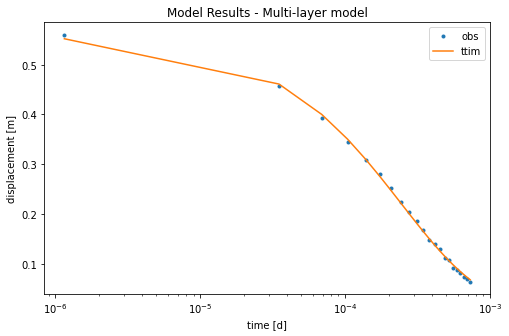

In [13]:
hm_1 = ml_1.head(0, 0, t)
plt.figure(figsize=(8, 5))
plt.semilogx(t, h, ".", label="obs")
plt.semilogx(t, hm_1[0], label="ttim")
plt.xlabel("time [d]")
plt.ylabel("displacement [m]")
plt.title("Model Results - Multi-layer model")
plt.legend()

## Step 8. Final Model calibration with well skin resistance

Now we test if the skin resistance of the well has an impact on model calibration. We thus add the ```res``` parameter in the calibration settings. We use the same multi-layer model.

In [14]:
ca_2 = Calibrate(ml_1)
ca_2.set_parameter(name="kaq0_48", initial=10, pmin=0)
ca_2.set_parameter(name="Saq0_48", initial=1e-4, pmin=1e-7)
ca_2.set_parameter_by_reference(name="res", parameter=w_1.res, initial=0.1, pmin=0)
ca_2.series(name="obs", x=0, y=0, layer=range(nlay), t=t, h=h)
ca_2.fit(report=True)

...................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 48
    # data points      = 1078
    # variables        = 3
    chi-square         = 0.02096895
    reduced chi-square = 1.9506e-05
    Akaike info crit   = -11687.6864
    Bayesian info crit = -11672.7378
[[Variables]]
    kaq0_48:  0.41949032 +/- 0.00255131 (0.61%) (init = 10)
    Saq0_48:  1.7431e-05 +/- 7.4956e-07 (4.30%) (init = 0.0001)
    res:      4.1889e-06 +/- 5.9899e-06 (142.99%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0_48, Saq0_48) = -0.986
    C(Saq0_48, res)     = -0.210
    C(kaq0_48, res)     = 0.188


In [15]:
display(ca_2.parameters)
print("RMSE:", ca_2.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_48,0.41949,2.551309e-03,0.608193,0,inf,10,"[0.41949032003442377, 0.41949032003442377, 0.4..."
Saq0_48,0.000017,7.495585e-07,4.300159,0.0,inf,0.0001,"[1.743095019002272e-05, 1.743095019002272e-05,..."
res,0.000004,5.989853e-06,142.994093,0,inf,0.1,[4.1888812432056e-06]


RMSE: 0.004410409508316654


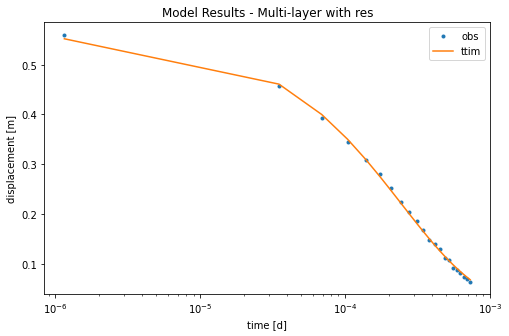

In [16]:
hm_2 = ml_1.head(0, 0, t)
plt.figure(figsize=(8, 5))
plt.semilogx(t, h, ".", label="obs")
plt.semilogx(t, hm_2[0], label="ttim")
plt.xlabel("time [d]")
plt.ylabel("displacement [m]")
plt.title("Model Results - Multi-layer with res")
plt.legend()

Adding resistance of the well screen does not improve the performance. Thus, res should not be applied in the conceptual model.

## Step 9. Analysis and comparison of simulated values

We now compare the values in TTim and add the results of the modelling done in MLU by Yang (2020).

In [17]:
ta = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]"],
    index=["MLU", "ttim", "ttim-multilayer", "ttim-res"],
)
tr = np.delete(ca_2.parameters["optimal"].values, 2)
ta.loc["MLU"] = [0.4133, 1.9388e-05]
ta.loc["ttim"] = ca.parameters["optimal"].values
ta.loc["ttim-multilayer"] = ca_1.parameters["optimal"].values
ta.loc["ttim-res"] = tr
ta["RMSE"] = [0.004264, ca.rmse(), ca_1.rmse(), ca_2.rmse()]
ta.style.set_caption("Comparison of parameter values and error under different models")

,k [m/d],Ss [1/m],RMSE
MLU,0.413300,0.000019,0.004264
ttim,0.421130,0.000017,0.004410
ttim-multilayer,0.421041,0.000017,0.004410
ttim-res,0.419490,0.000017,0.004410


Results are similar between all models. The RMSE of MLU is slightly better than the one from TTim. The one-layer model has accomplished the same results as more complex ones. Hence, we note the importance of trying simpler models to avoid adding unnecessary complexity.

## References

* Cooper Jr, H.H., Bredehoeft, J.D., Papadopulos, I.S., 1967. Response of a finite diameter well to an instantaneous charge of water. Water Resources Research 3, 263–269
* Hyder, Z., Butler Jr, J.J., McElwee, C.D., Liu, W., 1994. Slug tests in partially penetrating wells. Water Resources Research 30, 2945–2957.
* Duffield, G.M., 2007. AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Yang, Xinzhu (2020) Application and comparison of different methodsfor aquifer test analysis using TTim. Master Thesis, Delft University of Technology (TUDelft), Delft, The Netherlands.